# 04.5b Token Representation Analysis (Euclidean)

Analyze the distribution of token representations under the **Euclidean metric** (L2 norm).

**Purpose:** Compare to 04.5 (causal metric) to see if radial stratification is specific to the causal metric or also present in ordinary Euclidean space.

**Key questions:**
- What is the distribution of L2 norms across all 152k tokens?
- Are there distinct populations at different radii?
- How does this compare to the causal metric distribution?

**Method:**
1. Load all token embeddings (γ from lm_head.weight)
2. Compute Euclidean norm for each token: ||v||₂ = √(v^T v)
3. Visualize distribution with histogram
4. Identify and decode extreme tokens
5. Compare to causal metric findings

## Configuration

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

Using device: mps


## Load Model and Extract Gamma

In [9]:
# Load model for gamma matrix
print(f"Loading {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

# Extract gamma (unembedding matrix)
gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape
print(f"Gamma shape: {gamma.shape}")
print(f"Vocabulary size: {vocab_size:,} tokens")
print(f"Hidden dimension: {hidden_dim}")
print()

# Load tokenizer for decoding
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

Loading Qwen/Qwen3-4B-Instruct-2507...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gamma shape: torch.Size([151936, 2560])
Vocabulary size: 151,936 tokens
Hidden dimension: 2560

Tokenizer loaded.


## Compute Euclidean Norms for All Tokens

In [10]:
print("Computing Euclidean (L2) norms for all tokens...")
print(f"This is {vocab_size:,} vector norms: sqrt(v^T v)")
print()

# Compute all L2 norms
# ||v||₂ = sqrt(sum of squared components)
euclidean_norms = torch.norm(gamma, dim=1)  # [vocab_size]

print(f"Computed {len(euclidean_norms):,} Euclidean norms.")
print()

# Summary statistics
print("Euclidean Norm Distribution:")
print(f"  Min:    {euclidean_norms.min().item():.2f}")
print(f"  Mean:   {euclidean_norms.mean().item():.2f}")
print(f"  Median: {euclidean_norms.median().item():.2f}")
print(f"  Max:    {euclidean_norms.max().item():.2f}")
print(f"  Std:    {euclidean_norms.std().item():.2f}")
print()

# Coefficient of variation
cv = (euclidean_norms.std() / euclidean_norms.mean()).item()
print(f"Coefficient of variation: {cv:.4f} ({cv*100:.1f}%)")

Computing Euclidean (L2) norms for all tokens...
This is 151,936 vector norms: sqrt(v^T v)

Computed 151,936 Euclidean norms.

Euclidean Norm Distribution:
  Min:    0.36
  Mean:   1.09
  Median: 1.11
  Max:    1.61
  Std:    0.17

Coefficient of variation: 0.1546 (15.5%)


## Visualize Distribution

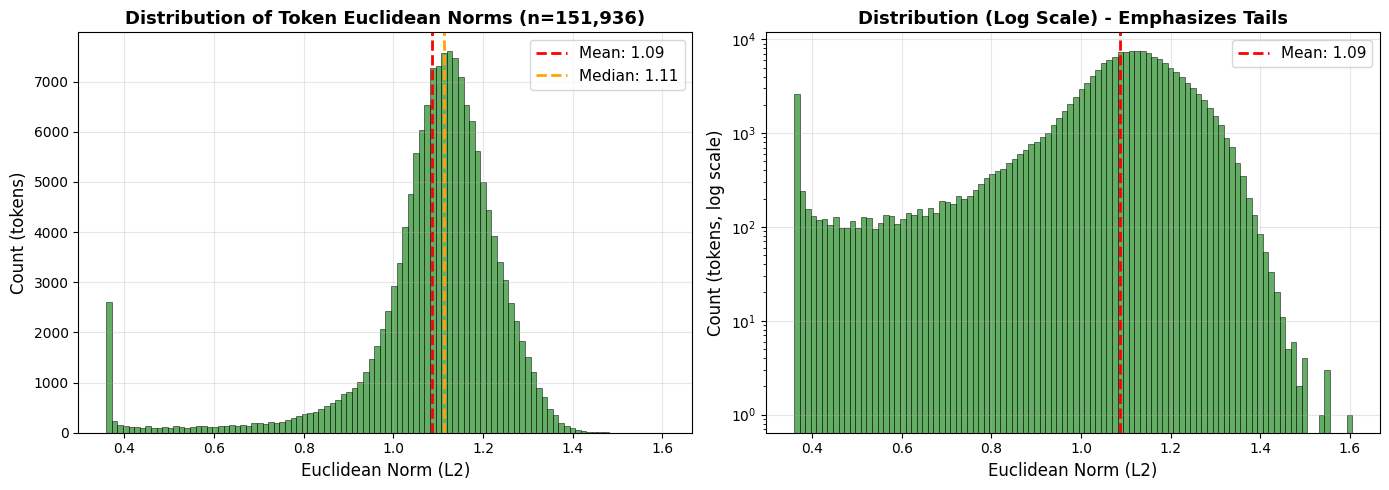


Histogram shows the full distribution across all 152k tokens.
Left: Linear scale (shows main peak)
Right: Log scale (emphasizes tails and secondary populations)


In [11]:
# Convert to numpy for plotting
norms_np = euclidean_norms.cpu().numpy()

# Create histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with fine bins
ax1.hist(norms_np, bins=100, color='forestgreen', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.axvline(norms_np.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {norms_np.mean():.2f}')
ax1.axvline(np.median(norms_np), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(norms_np):.2f}')
ax1.set_xlabel('Euclidean Norm (L2)', fontsize=12)
ax1.set_ylabel('Count (tokens)', fontsize=12)
ax1.set_title(f'Distribution of Token Euclidean Norms (n={vocab_size:,})', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Log-scale histogram to see tails
ax2.hist(norms_np, bins=100, color='forestgreen', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_yscale('log')
ax2.axvline(norms_np.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {norms_np.mean():.2f}')
ax2.set_xlabel('Euclidean Norm (L2)', fontsize=12)
ax2.set_ylabel('Count (tokens, log scale)', fontsize=12)
ax2.set_title('Distribution (Log Scale) - Emphasizes Tails', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nHistogram shows the full distribution across all 152k tokens.")
print("Left: Linear scale (shows main peak)")
print("Right: Log scale (emphasizes tails and secondary populations)")

## Identify Extreme Tokens

In [12]:
# Find tokens with smallest and largest Euclidean norms
n_extremes = 20

# Sort by Euclidean norm
sorted_indices = torch.argsort(euclidean_norms)

# Smallest norms
smallest_indices = sorted_indices[:n_extremes]
smallest_norms = euclidean_norms[smallest_indices]

# Largest norms  
largest_indices = sorted_indices[-n_extremes:].flip(0)  # Reverse to show largest first
largest_norms = euclidean_norms[largest_indices]

print(f"\n{'='*60}")
print(f"TOKENS WITH SMALLEST EUCLIDEAN NORMS (n={n_extremes})")
print(f"{'='*60}\n")

for i, (idx, norm) in enumerate(zip(smallest_indices, smallest_norms), 1):
    token_id = idx.item()
    token_str = tokenizer.decode([token_id])
    print(f"{i:2d}. Token {token_id:6d} | Norm: {norm.item():6.2f} | '{token_str}'")

print(f"\n{'='*60}")
print(f"TOKENS WITH LARGEST EUCLIDEAN NORMS (n={n_extremes})")
print(f"{'='*60}\n")

for i, (idx, norm) in enumerate(zip(largest_indices, largest_norms), 1):
    token_id = idx.item()
    token_str = tokenizer.decode([token_id])
    print(f"{i:2d}. Token {token_id:6d} | Norm: {norm.item():6.2f} | '{token_str}'")


TOKENS WITH SMALLEST EUCLIDEAN NORMS (n=20)

 1. Token 151666 | Norm:   0.36 | '</tool_response>'
 2. Token 150538 | Norm:   0.36 | 'ᕛ'
 3. Token 148095 | Norm:   0.36 | 'ﴀ'
 4. Token 150993 | Norm:   0.36 | '쒔'
 5. Token 147895 | Norm:   0.36 | '꿴'
 6. Token 151030 | Norm:   0.36 | '짥'
 7. Token 150895 | Norm:   0.36 | '뎟'
 8. Token 149856 | Norm:   0.36 | 'ﱅ'
 9. Token 151209 | Norm:   0.36 | 'ﰿ'
10. Token 151665 | Norm:   0.36 | '<tool_response>'
11. Token 150863 | Norm:   0.36 | '긿'
12. Token 149098 | Norm:   0.36 | '쏸'
13. Token 151231 | Norm:   0.36 | 'ﴰ'
14. Token 123206 | Norm:   0.36 | '�'
15. Token 149594 | Norm:   0.36 | 'ᰍ'
16. Token 151083 | Norm:   0.36 | '퍿'
17. Token 151000 | Norm:   0.36 | '엃'
18. Token 151551 | Norm:   0.36 | '퓮'
19. Token 150914 | Norm:   0.36 | '뛩'
20. Token 149771 | Norm:   0.36 | '쐴'

TOKENS WITH LARGEST EUCLIDEAN NORMS (n=20)

 1. Token  72363 | Norm:   1.61 | ' ​​'
 2. Token  18826 | Norm:   1.55 | 'edException'
 3. Token 118174 | Norm:   1.55 

## Percentile Analysis

In [13]:
# Compute percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(norms_np, percentiles)

print("\nPercentile Analysis:")
print(f"{'Percentile':<12} {'Euclidean Norm':>15}")
print("-" * 27)
for p, v in zip(percentiles, percentile_values):
    print(f"{p:>3d}th{' '*7} {v:>15.2f}")

# IQR (Interquartile Range)
q1, q3 = percentile_values[3], percentile_values[5]  # 25th and 75th
iqr = q3 - q1
print(f"\nInterquartile Range (IQR): {iqr:.2f}")
print(f"50% of tokens lie within [{q1:.2f}, {q3:.2f}]")


Percentile Analysis:
Percentile    Euclidean Norm
---------------------------
  1th                   0.37
  5th                   0.78
 10th                   0.94
 25th                   1.04
 50th                   1.11
 75th                   1.18
 90th                   1.24
 95th                   1.28
 99th                   1.34

Interquartile Range (IQR): 0.14
50% of tokens lie within [1.04, 1.18]


## Higher-Order Statistics

In [14]:
from scipy import stats

# Skewness and kurtosis
skewness = stats.skew(norms_np)
kurtosis = stats.kurtosis(norms_np)  # Excess kurtosis (normal = 0)

print("\nHigher-Order Statistics:")
print(f"  Skewness: {skewness:.4f}")
if skewness < -0.5:
    print("    → Left-skewed (heavy tail toward small values)")
elif skewness > 0.5:
    print("    → Right-skewed (heavy tail toward large values)")
else:
    print("    → Approximately symmetric")

print(f"\n  Kurtosis: {kurtosis:.4f}")
if kurtosis > 1:
    print("    → Heavy-tailed (more extreme values than normal distribution)")
elif kurtosis < -1:
    print("    → Light-tailed (fewer extreme values than normal)")
else:
    print("    → Similar tail behavior to normal distribution")

print("\nInterpretation:")
print("  These statistics quantify departures from a simple Gaussian.")
print("  Large |skewness| or |kurtosis| suggest multiple populations")
print("  or non-random structure in the distribution.")


Higher-Order Statistics:
  Skewness: -2.1652
    → Left-skewed (heavy tail toward small values)

  Kurtosis: 6.4940
    → Heavy-tailed (more extreme values than normal distribution)

Interpretation:
  These statistics quantify departures from a simple Gaussian.
  Large |skewness| or |kurtosis| suggest multiple populations
  or non-random structure in the distribution.


## Comparison to Causal Metric

**From notebook 04.5 (Causal metric):**
- Mean: 54.13 causal units
- Std: 7.90
- CV: 14.6%
- Skewness: -1.97 (heavy left tail)
- Kurtosis: 5.57 (very heavy tails)

**From this notebook (Euclidean metric):**
- Mean: (see above)
- Std: (see above)
- CV: (see above)
- Skewness: (see above)
- Kurtosis: (see above)

**Key comparison questions:**
1. Does Euclidean also show categorical stratification, or is it smooth/unimodal?
2. Are the same tokens extreme in both metrics?
3. Does Euclidean reveal the "training landscape" structure, or does that require the causal metric?

## Amplification Factor Analysis

**Key question:** Does the causal metric scale all tokens uniformly (~50×), or does it amplify some and suppress others?

We'll compute the ratio `causal_norm / euclidean_norm` for each token to see how M transforms individual vectors.

## Summary

This notebook computed the Euclidean norm ||v||₂ = √(v^T v) for all 151,936 tokens in the vocabulary.

**Purpose:** Baseline comparison to understand what structure is specific to the causal metric vs. what's already present in raw embedding geometry.

**Key findings:**
- Distribution shape (see histogram)
- Extreme tokens (smallest/largest L2 norms)
- Statistical characterization (percentiles, skewness, kurtosis)

**Interpretation:**
If Euclidean shows smooth distribution but causal shows stratification → the causal metric reveals training dynamics.

If both show similar structure → the radial organization might be a general property of high-dimensional token embeddings, not specific to the probability distribution captured by M.

In [15]:
# Load causal norms from 04.5
print("Loading causal norms from notebook 04.5...")
METRIC_PATH = Path("../data/vectors/causal_metric_tensor_qwen3_4b.pt")
metric_data = torch.load(METRIC_PATH, map_location=device, weights_only=True)
M = metric_data['M']

# Compute causal norms (same as 04.5)
causal_norms_squared = (gamma @ M * gamma).sum(dim=1)
causal_norms = torch.sqrt(torch.clamp(causal_norms_squared, min=0))

print(f"Loaded M: {M.shape}")
print(f"Computed {len(causal_norms):,} causal norms")
print()

# Compute amplification factor for each token
amplification = causal_norms / euclidean_norms

print("Amplification Factor Statistics:")
print(f"  (causal_norm / euclidean_norm for each token)")
print()
print(f"  Min:    {amplification.min().item():.2f}×")
print(f"  Mean:   {amplification.mean().item():.2f}×")
print(f"  Median: {amplification.median().item():.2f}×")
print(f"  Max:    {amplification.max().item():.2f}×")
print(f"  Std:    {amplification.std().item():.2f}×")
print()

# Coefficient of variation for amplification
cv_amp = (amplification.std() / amplification.mean()).item()
print(f"Coefficient of variation: {cv_amp:.4f} ({cv_amp*100:.1f}%)")
print()
print("Interpretation:")
print("  Low CV (~5-10%) → mostly uniform scaling")
print("  High CV (>20%) → differential reweighting (some tokens amplified way more)")

Loading causal norms from notebook 04.5...
Loaded M: torch.Size([2560, 2560])
Computed 151,936 causal norms

Amplification Factor Statistics:
  (causal_norm / euclidean_norm for each token)

  Min:    40.87×
  Mean:   49.97×
  Median: 49.65×
  Max:    80.16×
  Std:    2.07×

Coefficient of variation: 0.0415 (4.1%)

Interpretation:
  Low CV (~5-10%) → mostly uniform scaling
  High CV (>20%) → differential reweighting (some tokens amplified way more)


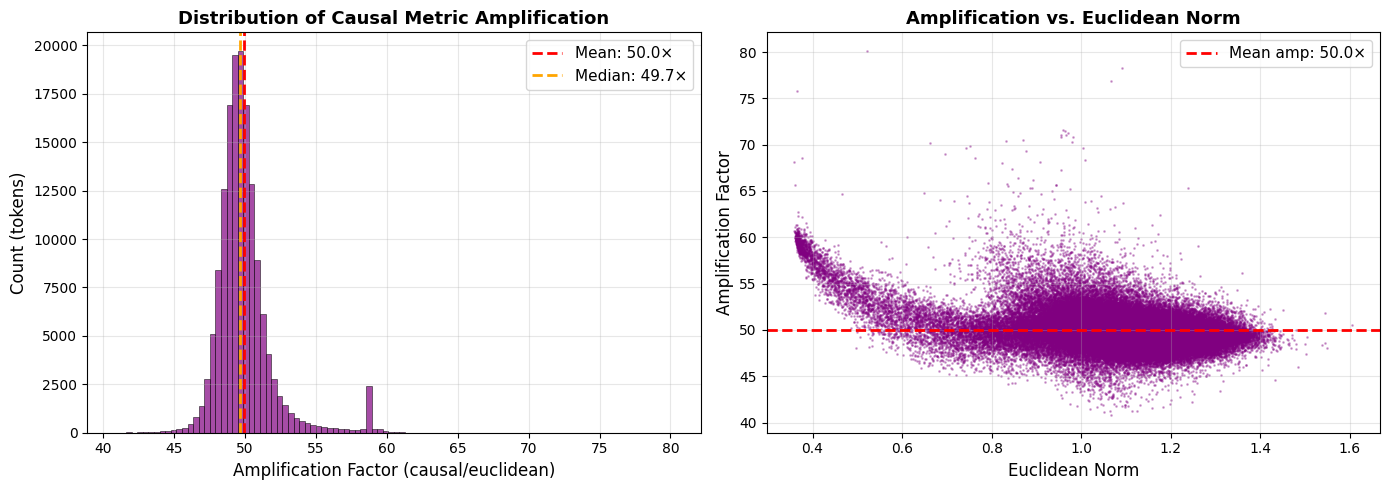


Left: Distribution of amplification factors
Right: Does amplification correlate with Euclidean magnitude?


In [16]:
# Visualize amplification distribution
amp_np = amplification.cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of amplification factors
ax1.hist(amp_np, bins=100, color='purple', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.axvline(amp_np.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {amp_np.mean():.1f}×')
ax1.axvline(np.median(amp_np), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(amp_np):.1f}×')
ax1.set_xlabel('Amplification Factor (causal/euclidean)', fontsize=12)
ax1.set_ylabel('Count (tokens)', fontsize=12)
ax1.set_title('Distribution of Causal Metric Amplification', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Scatter: Euclidean norm vs amplification factor
ax2.scatter(euclidean_norms.cpu().numpy(), amp_np, alpha=0.3, s=1, color='purple')
ax2.axhline(amp_np.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean amp: {amp_np.mean():.1f}×')
ax2.set_xlabel('Euclidean Norm', fontsize=12)
ax2.set_ylabel('Amplification Factor', fontsize=12)
ax2.set_title('Amplification vs. Euclidean Norm', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLeft: Distribution of amplification factors")
print("Right: Does amplification correlate with Euclidean magnitude?")

In [17]:
# Find tokens with extreme amplification factors
n_extremes = 20

# Sort by amplification
sorted_amp_indices = torch.argsort(amplification)

# Least amplified
least_amp_indices = sorted_amp_indices[:n_extremes]
least_amp_factors = amplification[least_amp_indices]

# Most amplified
most_amp_indices = sorted_amp_indices[-n_extremes:].flip(0)
most_amp_factors = amplification[most_amp_indices]

print(f"\n{'='*80}")
print(f"TOKENS WITH LEAST AMPLIFICATION (causal metric suppresses these)")
print(f"{'='*80}\n")

for i, (idx, amp) in enumerate(zip(least_amp_indices, least_amp_factors), 1):
    token_id = idx.item()
    token_str = tokenizer.decode([token_id])
    euc = euclidean_norms[idx].item()
    cau = causal_norms[idx].item()
    print(f"{i:2d}. Token {token_id:6d} | {amp.item():5.1f}× | Euc: {euc:4.2f} → Cau: {cau:5.1f} | '{token_str}'")

print(f"\n{'='*80}")
print(f"TOKENS WITH MOST AMPLIFICATION (causal metric emphasizes these)")
print(f"{'='*80}\n")

for i, (idx, amp) in enumerate(zip(most_amp_indices, most_amp_factors), 1):
    token_id = idx.item()
    token_str = tokenizer.decode([token_id])
    euc = euclidean_norms[idx].item()
    cau = causal_norms[idx].item()
    print(f"{i:2d}. Token {token_id:6d} | {amp.item():5.1f}× | Euc: {euc:4.2f} → Cau: {cau:5.1f} | '{token_str}'")


TOKENS WITH LEAST AMPLIFICATION (causal metric suppresses these)

 1. Token  35696 |  40.9× | Euc: 1.07 → Cau:  43.6 | ''));
'
 2. Token  32314 |  41.1× | Euc: 1.05 → Cau:  43.2 | '"];
'
 3. Token  15397 |  41.2× | Euc: 1.06 → Cau:  43.9 | '"));
'
 4. Token  97309 |  41.3× | Euc: 1.11 → Cau:  45.9 | ' ');
'
 5. Token  42012 |  41.3× | Euc: 1.12 → Cau:  46.4 | '!");
'
 6. Token  14090 |  41.5× | Euc: 1.02 → Cau:  42.3 | ''];
'
 7. Token  97469 |  41.6× | Euc: 1.16 → Cau:  48.1 | '.',
'
 8. Token  54491 |  41.6× | Euc: 1.03 → Cau:  43.1 | '"]);
'
 9. Token  93397 |  41.7× | Euc: 1.18 → Cau:  49.4 | '!";
'
10. Token  54203 |  41.7× | Euc: 1.10 → Cau:  45.8 | '.";
'
11. Token  25644 |  41.7× | Euc: 0.99 → Cau:  41.3 | '']);
'
12. Token  97937 |  41.8× | Euc: 1.10 → Cau:  46.1 | '"};
'
13. Token  37621 |  41.8× | Euc: 1.08 → Cau:  45.0 | '"],
'
14. Token  78254 |  41.8× | Euc: 1.09 → Cau:  45.6 | '.');
'
15. Token  72473 |  41.9× | Euc: 1.13 → Cau:  47.4 | ' ';
'
16. Token  40317 |  41.9× 